<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/k2_pix_small.png">
*This notebook contains an excerpt instructional material from [gully](https://twitter.com/gully_) and the [K2 Guest Observer Office](https://keplerscience.arc.nasa.gov/); the content is available [on GitHub](https://github.com/gully/goldenrod).*


<!--NAVIGATION-->
< [goldenrod](02.02-SN_model-fits.ipynb) | [Contents](Index.ipynb) | [Plot the data](02.04-KSN2011b_celerite.ipynb) >

# goldenrod

## 2. Astrophysical models

### Part III: Model other SN

Michael Gully-Santiago  
Wednesday, Aug 2, 2017

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

In [3]:
import astropy
import os
import pandas as pd
import seaborn as sns
from astropy.utils.console import ProgressBar
import everest
import sncosmo

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
everest_path = '../../everest/everest/missions/k2/tables/'
df_kegs = pd.read_csv('../metadata/KEGS_TPF_metadata.csv')
c05_everest = pd.read_csv(everest_path + 'c05.stars', names=['EPIC_ID', 'KepMag', 'Channel', 'col4'])
kegs_everest_c05 = pd.merge(df_kegs, c05_everest, how='inner', left_on='KEPLERID', right_on='EPIC_ID')

Get known supernovae from the KEGS website:

In [6]:
#! wget http://www.mso.anu.edu.au/kegs/data/repository/KSN2011b/KSN-2011b_raw_data.dat

In [7]:
#! wget http://www.mso.anu.edu.au/kegs/data/repository/KSN2011c/KSN-2011c_raw_data.dat

In [8]:
#! wget http://www.mso.anu.edu.au/kegs/data/repository/KSN2012a/KSN-2012a_raw_data.dat

In [9]:
#! mv *.dat ../data/

In [10]:
! head -n 20 ../data/KSN-2011b_raw_data.dat

In [65]:
KEGS_header = pd.read_csv('../data/KSN-2011b_raw_data.dat', skiprows=11, sep=r'\s{2,}', nrows=0, engine='python')
names = KEGS_header.columns.str.strip('#').str.replace(' ', '').str.replace('-', '_')
ksn2011b = pd.read_csv('../data/KSN-2011b_raw_data.dat', comment='#', names=names, delim_whitespace=True)
ksn2011b.head()

,KJD,KJD_T_EXP,KJD_T_MAX,LC_val_BCK,LC_err
0,964.77569,-29.98871,-49.04431,0.01157,0.01011
1,964.79613,-29.96827,-49.02387,0.00186,0.01027
2,964.81656,-29.94784,-49.00344,-0.00355,0.01065
3,964.83699,-29.92741,-48.98301,-0.00459,0.00976
4,964.85743,-29.90697,-48.96257,0.00710,0.01097


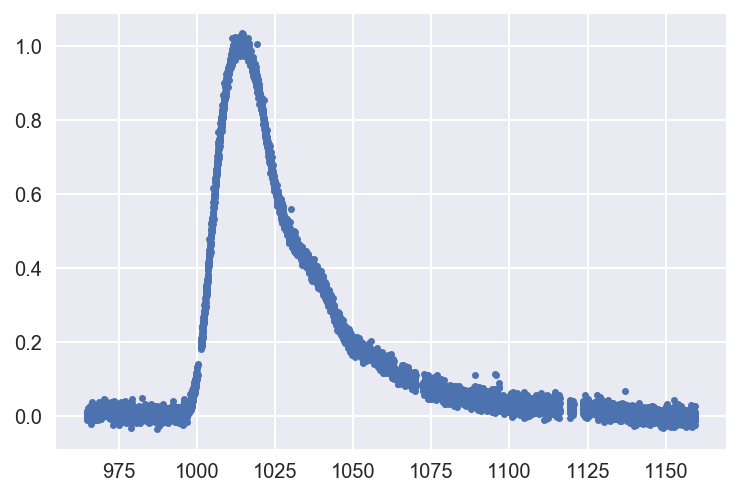

In [14]:
plt.plot(ksn2011b.KJD, ksn2011b.LC_val_BCK, '.')

In [15]:
model = sncosmo.Model(source='hsiao')

In [16]:
model.set(z=0, t0=1015., amplitude=5.5e-7)
model1 = model.bandflux('kepler', ksn2011b.KJD)

In [17]:
gal_raw = model1*0.0

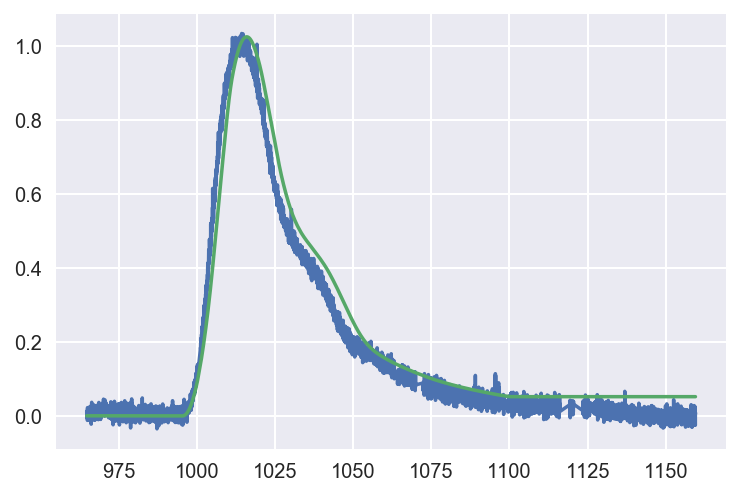

In [18]:
plt.plot(ksn2011b.KJD, ksn2011b.LC_val_BCK)
plt.plot(ksn2011b.KJD, model1+gal_raw)

In [19]:
resid = ksn2011b.LC_val_BCK - (model1+gal_raw)

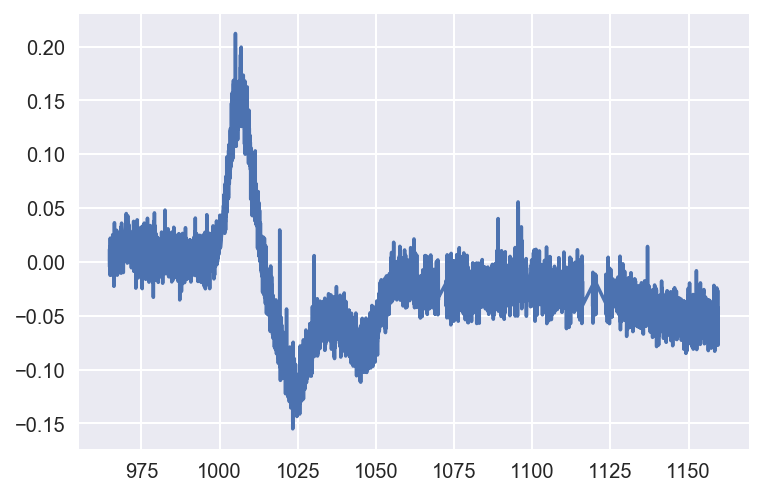

In [20]:
plt.plot(ksn2011b.KJD, resid)

In [21]:
ids = (ksn2011b.KJD> 1075) & (ksn2011b.KJD< 1095)
yerr = np.std(resid[ids])

In [66]:
yerr

0.011796557909976038

## Sampling!

In [22]:
y = ksn2011b.LC_val_BCK.values

In [23]:
iid_cov = np.diag( (y*0.0+yerr) ** 2)

In [24]:
def model_func(zz, t0, amp):
    model.set(z=zz, t0=t0, amplitude=amp)
    model1 = model.bandflux('kepler', ksn2011b.KJD)
    return model1

In [56]:
def lnlike(zz, t0, amp, lna, lns):
    a, s = np.exp(lna), np.exp(lns)
    off_diag_terms = a**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s**2)
    C = iid_cov + off_diag_terms
    sgn, logdet = np.linalg.slogdet(C)
    if sgn <= 0:
        return -np.inf
    r = y - model_func(zz, t0, amp)
    return -0.5 * (np.dot(r, np.linalg.solve(C, r)) + logdet)

In [57]:
# Apply a uniform prior over some range.
# Shape params are uniform in log space 
def lnprior(zz, t0,amp, lna, lns):
    if not (0< zz < 10 and 900 < t0 < 1150 and -12 < lna < -2 and 0 < lns < 8):
        return -np.inf
    return 0.0

In [58]:
def lnprob(p):
    lp = lnprior(*p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(*p)

In [59]:
import emcee

In [29]:
from numpy.random import multivariate_normal

In [38]:
x = ksn2011b.KJD
a_guess, s_guess = 0.03, 5.0
off_diag_terms = a_guess**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / s_guess**2)
C = iid_cov + off_diag_terms

In [32]:
C.shape

(8742, 8742)

In [34]:
sns.set_style('ticks')

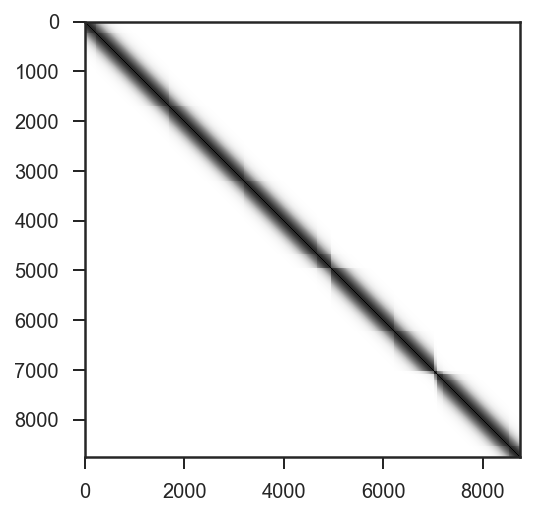

In [39]:
plt.imshow(C);

In [41]:
model1

array([  1.49445092e-20,   1.49445092e-20,   1.49445092e-20, ...,
         5.16857632e-02,   5.16857632e-02,   5.16857632e-02])

In [42]:
draw = multivariate_normal(model1, C)

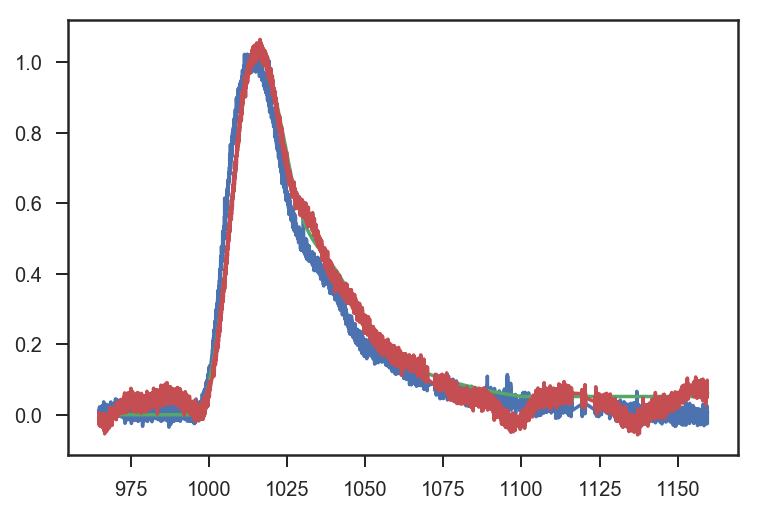

In [45]:
plt.plot(ksn2011b.KJD, ksn2011b.LC_val_BCK)
plt.plot(ksn2011b.KJD, model1)
plt.plot(ksn2011b.KJD, draw)

In [47]:
resid = ksn2011b.LC_val_BCK - (model1)

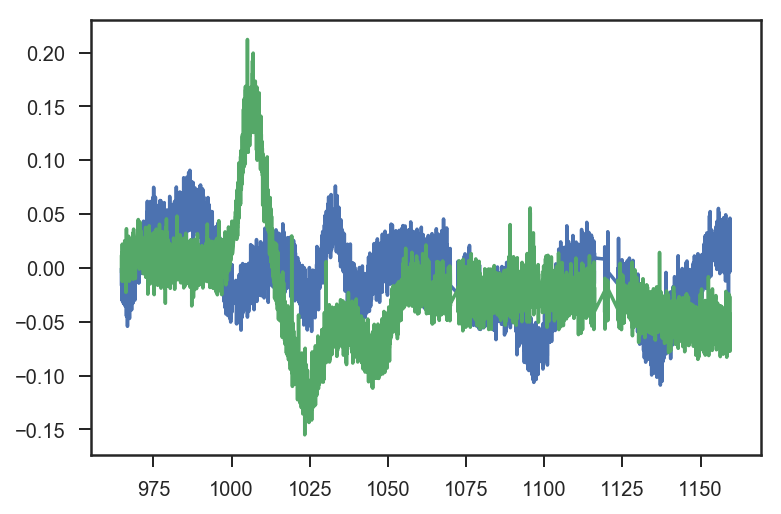

In [48]:
plt.plot(ksn2011b.KJD, draw -model1 )
plt.plot(ksn2011b.KJD, resid)

In [61]:
ndim, nwalkers = 5, 16
p0 = np.array([0.01, 1010.0, 1.0e-5, np.log(a_guess), np.log(s_guess)]) # Excellent guess
pos = [p0 + 1.0e-3*p0 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)

In [62]:
%%time
pos, lp, state = sampler.run_mcmc(pos, 1)
chain = sampler.chain

CPU times: user 1.4 s, sys: 444 ms, total: 1.84 s
Wall time: 11min 35s


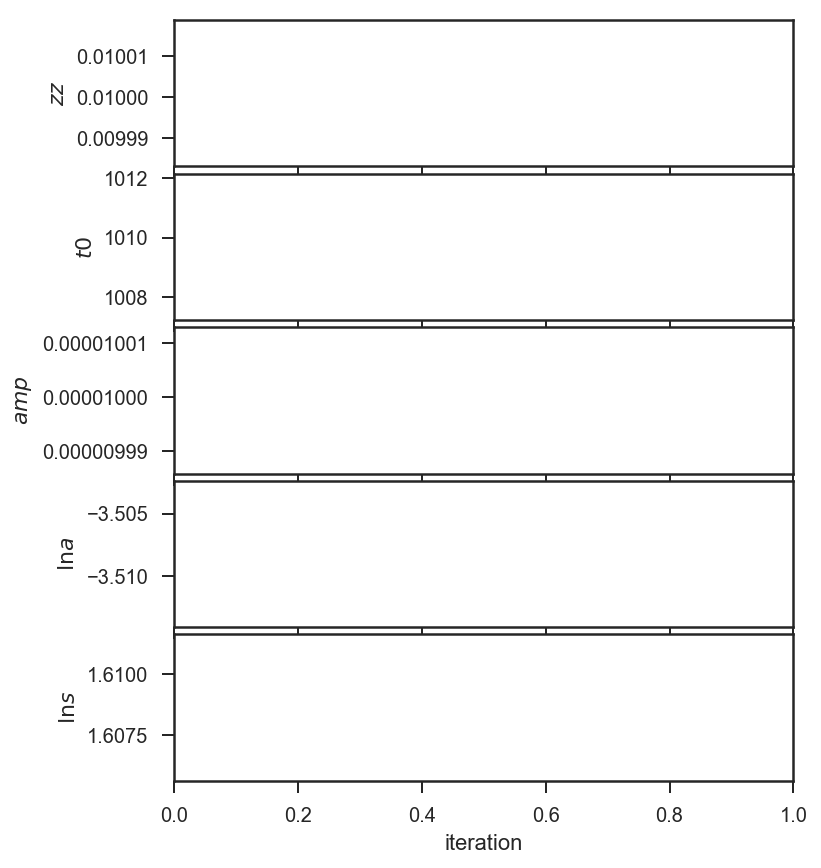

In [64]:
fig, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.96, top=0.98,
                    wspace=0.0, hspace=0.05)
[a.plot(np.arange(chain.shape[1]), chain[:, :, i].T, "k", alpha=0.5)
 for i, a in enumerate(axes)]
[a.set_ylabel("${0}$".format(l)) for a, l in zip(axes, ["zz", "t0", "amp", "\ln a", "\ln s"])]
axes[-1].set_xlim(0, chain.shape[1])
axes[-1].set_xlabel("iteration");

This event cannot be described by a traditional supernova model.

The end.

<!--NAVIGATION-->
< [goldenrod](02.02-SN_model-fits.ipynb) | [Contents](Index.ipynb) | [Plot the data](02.04-KSN2011b_celerite.ipynb) >